In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import math
import datetime
import category_encoders as ce

In [2]:
df = pd.read_csv('nfltrain.csv', low_memory=False)

# Understanding the data

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
display_all(df)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682149,2019112500,20191125003789,home,69.58,31.33,4.19,1.33,0.43,92.32,20.94,2556593,Cory Littleton,58,2019,38,4,04:11:00,BLT,2,9,BLT,6,45,2562407,PISTOL,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",left,2019-11-26T03:59:06.000Z,2019-11-26T03:59:05.000Z,4,6-3,228,11/18/1993,Washington,ILB,LA,BAL,12,Los Angeles Memorial Coliseum,"Los Angeles, CA",Outdoor,Grass,Clear,62.0,64.0,5,WSW
682150,2019112500,20191125003789,home,72.16,25.09,1.01,1.40,0.08,65.83,76.48,2558199,Tanzel Smart,92,2019,38,4,04:11:00,BLT,2,9,BLT,6,45,2562407,PISTOL,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",left,2019-11-26T03:59:06.000Z,2019-11-26T03:59:05.000Z,4,6-1,295,11/06/1994,Tulane,DT,LA,BAL,12,Los Angeles Memorial Coliseum,"Los Angeles, CA",Outdoor,Grass,Clear,62.0,64.0,5,WSW
682151,2019112500,20191125003789,home,72.23,31.95,1.75,0.68,0.17,93.99,90.26,2558830,Samson Ebukam,50,2019,38,4,04:11:00,BLT,2,9,BLT,6,45,2562407,PISTOL,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",left,2019-11-26T03:59:06.000Z,2019-11-26T03:59:05.000Z,4,6-3,245,05/09/1995,Eastern Washington,OLB,LA,BAL,12,Los Angeles Memorial Coliseum,"Los Angeles, CA",Outdoor,Grass,Clear,62.0,64.0,5,WSW
682152,2019112500,20191125003789,home,72.08,26.74,0.70,1.59,0.07,61.47,48.34,2562391,Greg Gaines,91,2019,38,4,04:11:00,BLT,2,9,BLT,6,45,2562407,PISTOL,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",left,2019-11-26T03:59:06.000Z,2019-11-26T03:59:05.000Z,4,6-1,312,05/06/1996,Washington,DT,LA,BAL,12,Los Angeles Memoria

There are 22 rows for each play with each row representing one of the 11 offensive and 11 defensive players on the field

### **What features are in the dataset?**

In [4]:
print(df.columns.values)

['GameId' 'PlayId' 'Team' 'X' 'Y' 'S' 'A' 'Dis' 'Orientation' 'Dir'
 'NflId' 'DisplayName' 'JerseyNumber' 'Season' 'YardLine' 'Quarter'
 'GameClock' 'PossessionTeam' 'Down' 'Distance' 'FieldPosition'
 'HomeScoreBeforePlay' 'VisitorScoreBeforePlay' 'NflIdRusher'
 'OffenseFormation' 'OffensePersonnel' 'DefendersInTheBox'
 'DefensePersonnel' 'PlayDirection' 'TimeHandoff' 'TimeSnap' 'Yards'
 'PlayerHeight' 'PlayerWeight' 'PlayerBirthDate' 'PlayerCollegeName'
 'Position' 'HomeTeamAbbr' 'VisitorTeamAbbr' 'Week' 'Stadium' 'Location'
 'StadiumType' 'Turf' 'GameWeather' 'Temperature' 'Humidity' 'WindSpeed'
 'WindDirection']


**Individual player-related values**: X, Y, S, A, Dis, Orientation, Dir, NflId, DisplayName, JerseyNumber, PlayerHeight, PlayerWeight, PlayerBirthDate, PlayerCollegeName, Position

**Condition-related values**: Location, StadiumType, Turf, GameWeather, Temperature, Humidity, WindSpeed, WindDirection

**Play-specific values**: Team (Home/Away), YardLine, Quarter, GameClock, PossessionTeam, Down, Distance, FieldPosition, HomeScoreBeforePlay, VisitorScoreBeforePlay, NflIdRusher, OffenseFormation,OffensePersonnel, DefendersInTheBox, DefensePersonnel, PlayDirection, TimeHandoff, TimeSnap, Yards 

**Game-related values**: Season,HomeTeamAbbr, VisitorTeamAbbr, Week, Stadium


### Which features contain null values?

In [5]:
df.isnull().sum()

GameId                         0
PlayId                         0
Team                           0
X                              0
Y                              0
S                              0
A                              0
Dis                            0
Orientation                   23
Dir                           28
NflId                          0
DisplayName                    0
JerseyNumber                   0
Season                         0
YardLine                       0
Quarter                        0
GameClock                      0
PossessionTeam                 0
Down                           0
Distance                       0
FieldPosition               8602
HomeScoreBeforePlay            0
VisitorScoreBeforePlay         0
NflIdRusher                    0
OffenseFormation              88
OffensePersonnel               0
DefendersInTheBox             22
DefensePersonnel               0
PlayDirection                  0
TimeHandoff                    0
TimeSnap  

### Correlation Matrix

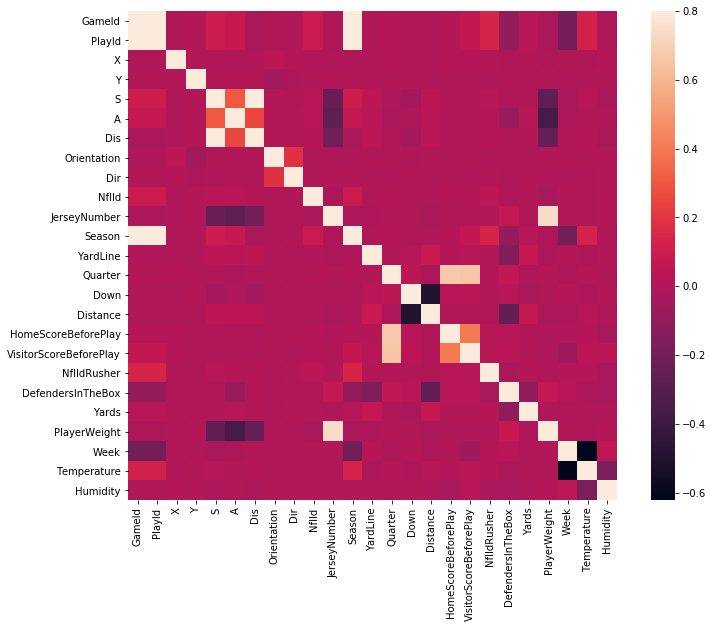

In [6]:
cormatrix = df.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(cormatrix, vmax=.8, square=True);

# Feature Cleaning

FieldPosition is always null when YardLine is 50. Therefore, I'll fill in null values with the 'Neutral' label

In [7]:
df.FieldPosition.fillna('Neutral', inplace=True)

Since adjacent rows are often from the same play and game, we can use forward filling and back filling to fill in the rest of the missing values, while maintaining the integrity of the data set.  

In [8]:
df = df.fillna(method='ffill').fillna(method='bfill')

StadiumType, Turf and GameWeather columns each have dozens of unique values, so I'll combine similar values to take one value

In [9]:
# Standardize to Indoors or Outdoors
df['StadiumType'] = df['StadiumType'].replace(['Outdoor', 'Open','Outddors', 'Oudoor','Ourdoor', 'Heinz Field', 
'Outdor', 'Cloudy', 'Bowl', 'Outside', 'Retractable Roof', 'Indoor, Open Roof', 'Outdoor Retr Roof-Open', 
'Retr. Roof - Open', 'Domed, Open', 'Domed, open', 'Indoor, roof open', 'OUTDOOR', 'Retr. Roof-Open'], 'Outdoors')
df['StadiumType'] = df['StadiumType'].replace(['Indoor', 'Dome','Domed, closed', 'Closed Dome',
'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Indoor, Roof Closed', 'Retr. Roof Closed', 'Domed', 'Outside',
                                        'Retractable Roof - Closed', 'Dome, closed', 'indoor'], 'Indoors')

In [10]:
# Standardize to Natural or Artificial
df['Turf'] = df['Turf'].replace(['Field Turf', 'A-Turf Titan', 'UBU Sports Speed S5-M', 'DD GrassMaster', 
        'UBU Speed Series-S5-M', 'FieldTurf', 'FieldTurf 360', 'Artifical', 'FieldTurf360', 'Field turf',
    'Twenty Four/Seven Turf','SISGrass', 'Twenty-Four/Seven Turf', 'UBU-Speed Series-S5-M', 'Turf'], 'Artificial')
df['Turf'] = df['Turf'].replace(['Grass', 'Natural Grass', 'Natural grass', 'grass', 'Naturall Grass', 'natural grass'], 'Natural')

In [11]:
# Standardize to Clear, Indoors, Snow, Rain or Cold 
df['GameWeather'] = df['GameWeather'].replace(['Clear and warm','Sun & clouds','Sunny','Mostly Sunny'\
                        'Clear','Mostly Cloudy','Mostly Coudy','Partly sunny', 'Partly Cloudy', 'Cloudy',\
                        'Sunny, highs to upper 80s','Partly cloudy','Partly Sunny', '30% Chance of Rain',\
                        'Cloudy, fog started developing in 2nd quarter','Coudy','Clear skies', 'cloudy', 'Fair', 'Mostly cloudy',\
                       'Cloudy, chance of rain','Party Cloudy','Hazy','Cloudy and Cool', 'Rain Chance 40%', 'Clear and sunny', 'Mostly sunny',\
                       'Sunny and warm', 'Partly clear', 'Cloudy, 50% change of rain','Clear and Sunny', 'Sunny, Windy', 'Clear and Cool',\
                        'Sunny and clear', 'Mostly Sunny Skies', 'Partly Clouidy','Clear Skies', 'Sunny Skies', 'Overcast',\
                           'T: 51; H: 55; W: NW 10 mph','Clear and cold','Partly cloudy and mild','Breezy','partly cloudy',\
                                                        'Mostly Clear','sUNNY','overcast','Mostly clear','Mostly Sunny'],'Clear')
df['GameWeather'] = df['GameWeather'].replace(['Controlled Climate', 'Indoors', 'N/A (Indoors)',\
                            'N/A Indoor','Indoor','N/A Indoors'],'Indoors')
df['GameWeather'] = df['GameWeather'].replace(['Light Rain','Showers',\
                        'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',\
                         'Rain likely, temps in low 40s.','Scattered Showers', 'Cloudy, Rain', 'Rain shower',\
                            'Rainy','Light rain','Cloudy with showers and wind','Raining', 'Rain and Wind'],'Rain')
df['GameWeather'] = df['GameWeather'].replace(['Heavy lake effect snow', 'Cloudy, light snow accumulating 1-3"'],'Snow')
df['GameWeather'] = df['GameWeather'].replace(['Cloudy and cold','Sunny and cold'],'Cold')

The team abbreviations for a few teams differ across the PossessionTeam and FieldPosition columns so I'll fix those to reference the same values.

In [12]:
df['PossessionTeam'] = df['PossessionTeam'].replace('BLT','BAL')
df['PossessionTeam'] = df['PossessionTeam'].replace('CLV','CLE')
df['PossessionTeam'] = df['PossessionTeam'].replace('ARZ','ARI')
df['PossessionTeam'] = df['PossessionTeam'].replace('HST','HOU')

df['FieldPosition'] = df['FieldPosition'].replace('BLT','BAL')
df['FieldPosition'] = df['FieldPosition'].replace('CLV','CLE')
df['FieldPosition'] = df['FieldPosition'].replace('ARZ','ARI')
df['FieldPosition'] = df['FieldPosition'].replace('HST','HOU')

I'll convert numeric and datetime objects to their respective types so I can use their values later on for feature engineering.

In [13]:
# Convert column types from objects to datetime and numeric values 
df['DefendersInTheBox'] = pd.to_numeric(df["DefendersInTheBox"],errors='coerce')
df['PlayerBirthDate'] = pd.to_datetime(df["PlayerBirthDate"], format='%m/%d/%Y', errors='coerce')
df['TimeHandoff'] = pd.to_datetime(df['TimeHandoff'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
df['TimeSnap'] = pd.to_datetime(df['TimeSnap'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

In [14]:
# Convert game clock from object type to float 
def to_seconds(str):
    split_str = str.split(':')
    return int(split_str[0])*60 + int(split_str[1]) + int(split_str[2])/60
df['GameClock'] = df['GameClock'].apply(lambda x: to_seconds(x))

In [15]:
# Convert player height from object type to int
def to_inches(height):
    ft_inch = height.split('-')
    feet = int(ft_inch[0])
    inch = int(ft_inch[1])
    return (feet*12) + inch 
    
df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: to_inches(x))

### Standardize YardLine 
For the model to better understand the direction of each play, I want to standardize all plays so that the offense is always moving from left to right.

Therefore, instead of spanning from 0 to 50, YardLine will span the entire field and range from 0 to 120 (100 yards + Left Endzone + Right Endzone)

In [16]:
def yardLine(posTeam, fieldPosition, yardLine):
    # Still on own field side - we have to account for the endzone too
    if posTeam == fieldPosition: 
        return 10 + yardLine
    else: 
        return 60 + (50 - yardLine)
    
df['YardLine'] = df[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: yardLine(x[0],x[1],x[2]), axis=1)

### Standardize Positions, Orientation and Direction
I want to standardize the values so that the offensive team is always moving from left to right. Therefore, if the play is moving from right to left, we have to flip the "field" in that play. So if the offense is oriented to the left, I'll flip them to orient towards the right, and the defense will be oriented to the left. 

In [17]:
def standardize_x(x, playDir):
    if playDir == 'left':
        return 120 - x
    else:
        return x
        
df["X"] = df[['X','PlayDirection']].apply(lambda x: standardize_x(x[0],x[1]), axis=1)

In [18]:
def standardize_y(y, playDir):
    if playDir == 'left':
        return 53.3 - float(y)
    else:
        return y
        
df["Y"] = df[['Y','PlayDirection']].apply(lambda y: standardize_y(y[0],y[1]), axis=1)

In [19]:
def standardize_orientation(ori, playDir):
    if playDir == 'left':
        return 180 + ori
    else:
        return ori
    
df["Orientation"] = df[['Orientation','PlayDirection']].apply(lambda x: standardize_orientation(x[0],x[1]), axis=1)

In [20]:
def standardize_direction(direc, playDir):
    if playDir == 'left':
        return 180 + direc
    else:
        return direc
    
df["Dir"] = df[['Dir','PlayDirection']].apply(lambda x: standardize_direction(x[0],x[1]), axis=1)

**I'm going to drop the below rows for their own reasons:**
* WindDirection, WindSpeed: It isn't known whether every stadium is aligned the same way, with endzones facing Earth's east and west. Therefore, these columns don't indicate much about the outcome of the play
* Humidity: Humidity has little correlation with the yards gained on a run play, and there aren't any features to engineer.
* Stadium, Location: Stadium and Location only help understand whether the team is home or away, but we already have the Team column that indicates home/away status. Dropping Stadium and Location will reduce the noise in the model
* PlayerCollegeName: This column contains hundreds of unique values and has little correlation to how well a player can perform. 
* PlayDirection: Since we've normalized X and Y values so that the offense is always moving from left to right, PlayDirection no longer matters
* As you'll see soon, we're only going to be keeping rows that correspond to the Rusher, which 99% of the time will be a RB. (Sometimes it can be a WR)

In [21]:
df.drop(['Humidity','WindSpeed','WindDirection','Location','Stadium','PlayerCollegeName','PlayDirection','Position'], axis=1, inplace=True)

Now, I've finished normalizing values for each player across all plays.

Ultimately, I want to feed into the model a dataframe where each row is a unique play. To do that, I've chosen to consolidate the rows based on the Rusher so the model can at least retain knowledge of Rusher specific values (ex. Height, BodyWeight etc.) This will be the dataframe we use to train the model.

In [22]:
train_df = df[df['NflId'] == df['NflIdRusher']]

# Feature Engineering

### Creating defensive team features
As a result of consolidating the dataframe to only include Rusher rows, I've lost data about the defensive team. Taking inspiration from a public notebook, I found that I could at least gather a summary of the defensive team's positions. 

Notebook: https://www.kaggle.com/coolcoder22/nfl-001-random-forest

In [23]:
def distance(rush_x, rush_y, def_x, def_y):
    return abs(math.sqrt(pow(def_x - rush_x, 2) + pow(def_y - rush_y, 2)))

def defense_features(df):
    # Pull rusher specific values into a temporary df 
    rusher_df = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
    rusher_df.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

    # Get only rows corresponding to the defensive team, but include rusher specific values 
    defense_df = pd.merge(df,rusher_df,on=['GameId','PlayId'],how='inner')
    defense_df = defense_df[defense_df['Team'] != defense_df['RusherTeam']]
    
    # Calculate distance from each defensive player to the rusher 
    defense_df['DistanceFromRusher'] = defense_df[['RusherX','RusherY','X','Y']].apply(lambda x: distance(x[0],x[1],x[2],x[3]), axis=1)
    defense_df = defense_df[['GameId','PlayId','DistanceFromRusher']]
    
    # Collect min, max, mean, and std of distance from defensive players to the rusher for each play 
    defense_df = defense_df.groupby(['GameId','PlayId']).agg({'DistanceFromRusher':['min','max','mean','std']}).reset_index()
    defense_df.columns = ['GameId','PlayId','Def_min_dis_to_rusher','Def_max_dis_to_rusher','Def_mean_dis_to_rusher','Def_std_dis_to_rusher']
    return defense_df
    
defense_df = defense_features(df)
train_df = pd.merge(train_df, defense_df, on=['GameId','PlayId'], how='inner')

### Count specific positions on the field
Here, I'll replace the OffensePersonnel and DefensePersonnel columns with separate columns that describe the number of players at that position. 

In [24]:
def offense(df):
    personnel = df['OffensePersonnel']
    RB = 0
    TE = 0
    WR = 0
    OL = 0
    QB = 0
    prevChar = personnel[0]
    positions = ['OL','RB','TE','WR','LB']
    for i in range(len(personnel)): 
        symbol = prevChar + personnel[i]
        if symbol in positions:
            count = personnel[i-3]
            if (symbol == 'OL'):
                OL = int(count)
            elif (symbol == 'RB'):
                RB = int(count)
            elif (symbol == 'TE'):
                TE = int(count)
            elif (symbol == 'WR'):
                WR = int(count)
            elif (symbol == 'QB'):
                QB = int(count)
        prevChar = personnel[i]
        
    # Default to 1 QB 
    if (QB == 0):
        QB = 1
    
    # Handle cases w/ strange offense personnel such as having a DB or LB which are defensive positions 
    # I'll assume those become an OL position 
    if (OL == 0) | (RB + TE + WR + OL + QB != 11):
        OL = 11 - RB - TE - WR - QB 
        
    df['RB'] = RB
    df['TE'] = TE
    df['WR'] = WR
    df['OL'] = OL
    df['QB'] = QB
    return df 

train_df = train_df.apply(offense, axis=1)
train_df.drop('OffensePersonnel',axis=1, inplace=True)

In [25]:
def defense(df):
    personnel = df['DefensePersonnel']
    DL = 0
    DB = 0
    LB = 0
    prevChar = personnel[0]
    positions = ['DL','DB','LB']
    for i in range(len(personnel)): 
        symbol = prevChar + personnel[i]
        if symbol in positions:
            count = personnel[i-3]
            if (symbol == 'DL'):
                DL = int(count)
            elif (symbol == 'DB'):
                DB = int(count)
            elif (symbol == 'LB'):
                LB = int(count)
        prevChar = personnel[i]
        
    # Handle cases w/ strange defensive personnel such as having a RB or OL which are offensive positions 
    # I'll assume those take on DL positions 
    if (DL == 0) | (DL + DB + LB!= 11):
        OL = 11 - DB - LB
        
    df['DL'] = DL
    df['DB'] = DB
    df['LB'] = LB
    return df

train_df = train_df.apply(defense, axis=1)
train_df.drop('DefensePersonnel',axis=1, inplace=True)

### Specify if defensive team is running rush defense
If the offensive team has more blockers than the defensive team has tacklers, that can potentially allow the Rusher to gain more yards. We'll calculate the difference in blockers and defensive team, so a positive number indicates there are more blockers than tacklers, and a negative number indicates there are less.

In [26]:
def line_diff(ol,te,dl,lb):
    return (ol + te) - (dl + lb)

train_df['TacklerBlockerDifference'] = train_df[['OL','TE','DL','LB']].apply(lambda x: line_diff(x[0],x[1],x[2],x[3]), axis=1)

### Get rusher age and distance behind the scrimmage line

In [27]:
def get_year(handoff, birth):
    age = handoff.year - birth.year - ((handoff.year, handoff.day) < (birth.month, birth.day))
    return age

train_df['Age'] = train_df[['TimeHandoff','PlayerBirthDate']].apply(lambda x: get_year(x[0],x[1]), axis=1)
# We no longer need the datetime columns
train_df.drop(['TimeHandoff','PlayerBirthDate','TimeSnap'], axis=1, inplace=True)

As context, rushers normally line up a few yards behind the scrimmage line. 

Since we standardized YardLine and X earlier, we can use these two values to find exactly how far back the rusher lined up. 

In [28]:
def distance_behind_line(x, yardLine):
    return yardLine - x

train_df['DistanceBehindLine'] = train_df[['X','YardLine']].apply(lambda x: distance_behind_line(x[0],x[1]),axis=1)

### Get distance to endzone
Since the length of the field shortens as you get closer to the endzone, the span of the defense compresses, and the average distance between the entire defense and the rusher shortens. Therefore, it may be useful to know how close to the endzone the rushing team is.

In [29]:
def distance_to_endzone(yardLine):
    return 110 - yardLine

train_df['DistanceToEndzone'] = train_df[['YardLine']].apply(lambda x: distance_to_endzone(x[0]), axis=1)

## Final dataframe

In [30]:
display_all(train_df)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,HomeTeamAbbr,VisitorTeamAbbr,Week,StadiumType,Turf,GameWeather,Temperature,Def_min_dis_to_rusher,Def_max_dis_to_rusher,Def_mean_dis_to_rusher,Def_std_dis_to_rusher,RB,TE,WR,OL,QB,DL,DB,LB,TacklerBlockerDifference,Age,DistanceBehindLine,DistanceToEndzone
0,2017090700,20170907000118,home,41.25,22.77,3.63,3.35,0.38,341.98,425.74,2543773,James White,28,2017,45,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,6.0,8,70,205,NE,KC,1,Outdoors,Artificial,Clear,63.0,4.593310,22.415872,9.752491,5.327299,1,1,3,5,1,2,6,3,1,25,3.75,65
1,2017090700,20170907000139,home,48.93,26.14,3.06,2.41,0.34,390.70,492.20,2543773,James White,28,2017,53,1,832.0,NE,1,10,NE,0,0,2543773,SHOTGUN,6.0,3,70,205,NE,KC,1,Outdoors,Artificial,Clear,63.0,4.287773,23.025872,10.297028,5.833217,1,1,3,5,1,2,6,3,1,25,4.07,57
2,2017090700,20170907000189,home,71.34,34.19,5.77,2.42,0.60,320.82,401.96,2543773,James White,28,2017,75,1,782.0,NE,1,10,KC,0,0,2543773,SINGLEBACK,7.0,5,70,205,NE,KC,1,Outdoors,Artificial,Clear,63.0,4.221670,20.726285,9.903689,5.073290,1,1,3,5,1,2,6,3,1,25,3.66,35
3,2017090700,20170907000345,home,104.47,27.94,4.45,3.20,0.46,366.22,455.44,2539663,Mike Gillislee,35,2017,108,1,732.0,NE,2,2,KC,0,0,2539663,JUMBO,9.0,2,71,210,NE,KC,1,Outdoors,Artificial,Clear,63.0,4.528002,9.791231,6.309354,1.834174,2,2,0,6,1,4,3,4,0,27,3.53,2
4,2017090700,20170907000395,away,29.99,27.12,3.90,2.53,0.44,34.27,157.92,2557917,Kareem Hunt,27,2017,35,1,728.0,KC,1,10,KC,7,0,2557917,SHOTGUN,7.0,7,71,216,NE,KC,1,Outdoors,Artificial,Clear,63.0,4.288088,21.214806,11.056456,5.900009,1,3,1,5,1,3,6,2,3,22,5.01,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31002,2019112500,20191125003419,away,51.05,25.02,4.26,2.54,0.42,423.61,435.90,2562407,Justice Hill,43,2019,56,4,587.0,BAL,1,10,BAL,6,42,2562407,PISTOL,8.0,1,70,200,LA,BAL,12,Outdoors,Natural,Clear,62.0,4.867494,11.417968,7.615745,2.253766,2,2,1,5,1,4,4,3,0,22,4.95,54
31003,2019112500,20191125003440,away,50.89,27.11,4.49,3.14,0.43,429.98,443.67,2562407,Justice Hill,43,2019,57,4,543.0,BAL,2,9,BAL,6,42,2562407,PISTOL,7.0,1,70,200,LA,BAL,12,Outdoors,Natural,Clear,62.0,6.051289,19.113202,10.701556,4.375654,1,1,3,5,1,3,5,3,0,22,6.11,53
31004,2019112500,20191125003496,away,92.56,28.84,4.42,1.54,0.43,443.76,464.49,2561324,Gus Edwards,35,2019,97,4,484.0,BAL,1,10,LA,6,42,2561324,SINGLEBACK,8.0,1,73,238,LA,BAL,12,Outdoors,Natural,Clear,62.0,4.975229,15.721387,7.933500,3.376218,1,1,3,5,1,3,5,3,0,24,4.44,13
31005,2019112500,20191125003768,away,41.54,24.90,4.80,3.26,0.47,454.83,442.25,2562407,Justice Hill,43,2019,47,4,295.0,BAL,1,10,BAL,6,45,2562407,PISTOL,7.0,1,70,200,LA,BAL,12,Outdoors,Natural,Clear,62.0,5.807452,19.452889,9.024748,4.343820,2,1,2,5,1,4,4,3,-1,22,5.46,63


## Model training

In [31]:
# Evaluation metric 
def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_true.shape[0]) 

In [32]:
# Encode categorical features using Target Encoder
cat_features = ['Team', 'DisplayName', 'PossessionTeam', 'FieldPosition', 
                'HomeTeamAbbr', 'VisitorTeamAbbr', 'StadiumType',
               'Turf', 'GameWeather', 'OffenseFormation']
target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(train_df[cat_features], train_df['Yards'])
train_df[cat_features] = target_enc.transform(train_df[cat_features], train_df['Yards'])

In [33]:
display_all(train_df)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,HomeTeamAbbr,VisitorTeamAbbr,Week,StadiumType,Turf,GameWeather,Temperature,Def_min_dis_to_rusher,Def_max_dis_to_rusher,Def_mean_dis_to_rusher,Def_std_dis_to_rusher,RB,TE,WR,OL,QB,DL,DB,LB,TacklerBlockerDifference,Age,DistanceBehindLine,DistanceToEndzone
0,2017090700,20170907000118,4.273228,41.25,22.77,3.63,3.35,0.38,341.98,425.74,2543773,4.162791,28,2017,45,1,854.0,4.265487,3,2,4.371692,0,0,2543773,4.468740,6.0,8,70,205,4.434524,4.710366,1,4.231341,4.228677,4.261532,63.0,4.593310,22.415872,9.752491,5.327299,1,1,3,5,1,2,6,3,1,25,3.75,65
1,2017090700,20170907000139,4.273228,48.93,26.14,3.06,2.41,0.34,390.70,492.20,2543773,4.162791,28,2017,53,1,832.0,4.265487,1,10,4.371692,0,0,2543773,4.468740,6.0,3,70,205,4.434524,4.710366,1,4.231341,4.228677,4.261532,63.0,4.287773,23.025872,10.297028,5.833217,1,1,3,5,1,2,6,3,1,25,4.07,57
2,2017090700,20170907000189,4.273228,71.34,34.19,5.77,2.42,0.60,320.82,401.96,2543773,4.162791,28,2017,75,1,782.0,4.265487,1,10,4.609409,0,0,2543773,4.212960,7.0,5,70,205,4.434524,4.710366,1,4.231341,4.228677,4.261532,63.0,4.221670,20.726285,9.903689,5.073290,1,1,3,5,1,2,6,3,1,25,3.66,35
3,2017090700,20170907000345,4.273228,104.47,27.94,4.45,3.20,0.46,366.22,455.44,2539663,3.550000,35,2017,108,1,732.0,4.265487,2,2,4.609409,0,0,2539663,1.812408,9.0,2,71,210,4.434524,4.710366,1,4.231341,4.228677,4.261532,63.0,4.528002,9.791231,6.309354,1.834174,2,2,0,6,1,4,3,4,0,27,3.53,2
4,2017090700,20170907000395,4.181352,29.99,27.12,3.90,2.53,0.44,34.27,157.92,2557917,4.715812,27,2017,35,1,728.0,4.593533,1,10,4.609409,7,0,2557917,4.468740,7.0,7,71,216,4.434524,4.710366,1,4.231341,4.228677,4.261532,63.0,4.288088,21.214806,11.056456,5.900009,1,3,1,5,1,3,6,2,3,22,5.01,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31002,2019112500,20191125003419,4.181352,51.05,25.02,4.26,2.54,0.42,423.61,435.90,2562407,3.810811,43,2019,56,4,587.0,4.467712,1,10,4.571272,6,42,2562407,4.625128,8.0,1,70,200,4.345691,4.043434,12,4.231341,4.226777,4.261532,62.0,4.867494,11.417968,7.615745,2.253766,2,2,1,5,1,4,4,3,0,22,4.95,54
31003,2019112500,20191125003440,4.181352,50.89,27.11,4.49,3.14,0.43,429.98,443.67,2562407,3.810811,43,2019,57,4,543.0,4.467712,2,9,4.571272,6,42,2562407,4.625128,7.0,1,70,200,4.345691,4.043434,12,4.231341,4.226777,4.261532,62.0,6.051289,19.113202,10.701556,4.375654,1,1,3,5,1,3,5,3,0,22,6.11,53
31004,2019112500,20191125003496,4.181352,92.56,28.84,4.42,1.54,0.43,443.76,464.49,2561324,5.238739,35,2019,97,4,484.0,4.467712,1,10,4.596907,6,42,2561324,4.212960,8.0,1,73,238,4.345691,4.043434,12,4.231341,4.226777,4.261532,62.0,4.975229,15.721387,7.933500,3.376218,1,1,3,5,1,3,5,3,0,24,4.44,13
31005,2019112500,20191125003768,4.181352,41.54,24.90,4.80,3.26,0.47,454.83,442.25,2562407,3.810811,43,2019,47,4,295.0,4.467712,1,10,4.571272,6,45,2562407,4.625128,7.0,1,70,200,4.345691,4.043434,12,4.231341,4.226777,4.261532,62.0,5.807452,19.452889,9.024748,4.343820,2,1,2,5,1,4,4,3,-1,22,5.46,63


In [34]:
X = train_df.copy()
yards = X.Yards

# Initialize output array format 
# There are 199 indexes, corresponding to -99 -> 99 yards gained on a play
output = np.zeros((yards.shape[0], 199))

# For every play, mark 1 at the index that represents the yards gained on that play 
for i, yards in enumerate(list(yards)):
    output[i][99+yards] = 1
    
X.drop(['GameId','PlayId','Yards'], axis=1, inplace=True)

kf = KFold(n_splits=5, random_state=None)

# Standardize features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

scores = []
models = []

for train_index, test_index in kf.split(X):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = output[train_index], output[test_index]
    model = RandomForestRegressor(n_estimators=80, max_depth=10, min_samples_split= 5, min_samples_leaf=1, max_features='auto', bootstrap=True, n_jobs=-1)
    model.fit(X_train, y_train)
    score = crps(y_test, model.predict(X_test))
    scores.append(score)
    print("Score:", score)
    models.append(model)

print("Mean score:", (sum(scores)/len(scores)))

Score: 0.012493502959315844
Score: 0.01231120225092699
Score: 0.014082229303521522
Score: 0.014177508477556033
Score: 0.013166248049880779
Mean score: 0.013246138208240232


## Saving the model and data preparation objects

In [35]:
import joblib

In [37]:
model_file = "nfl_model1.pkl"  
scaler_file = "nfl_scaler1.pkl"
encoder_file = "nfl_encoder1.pkl"

joblib.dump(models[0], model_file)
joblib.dump(scaler, scaler_file)
joblib.dump(target_enc, encoder_file)

['nfl_encoder1.pkl']